# Load Packages and other prerequisite

In [4]:
import sys
import os
import re
from datetime import datetime
from itertools import (combinations, combinations_with_replacement,
                       permutations, product)

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.linalg as la
import scipy.sparse as sp
import seaborn as sns
import statsmodels.api as sm
from mpl_toolkits.mplot3d import Axes3D
from regpyhdfe import Regpyhdfe
from scipy.stats import (beta, binom, dirichlet, expon, lognorm,
                         multivariate_normal, norm, pareto)
from tqdm import notebook, trange
import cvxpy as cp
import pickle 

pd.set_option('display.max_columns', None)

## Pytorch Packages

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.optim.lr_scheduler as LR_scheduler
import torch.utils.data as data
from torch.distributions.beta import Beta
from torch.distributions.gamma import Gamma
from torch.distributions.kumaraswamy import Kumaraswamy
from torch.distributions.log_normal import LogNormal
from torch.distributions.normal import Normal
from torch.distributions.uniform import Uniform
from tqdm import tqdm_notebook, trange

# global torch_device
# torch_device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
# print(torch_device)

In [6]:
current_directory = os.getcwd()
parent_directory = os.path.dirname(current_directory)
sys.path.append(parent_directory)
if parent_directory not in sys.path:
    sys.path.append(parent_directory)
from config import directory_path
os.chdir(directory_path)
os.getcwd()



'C:\\Users\\nadav\\Dropbox\\uchicago_fourth\\uncertaintyInequality'

## Loading Custom Functions

In [7]:
%load_ext autoreload
%autoreload 2

import bin2.setGlobals as gl 
from bin2.prePrcoessingFunc import * 
from bin2.sampleFunctions import *
from bin2.trainFunctions import *
from bin2.FlowModel import *
from bin2.solvingConsumptionFunc import *

# global torch_device
# torch_device = gl.torch_device


# Data Preprocessing (Logarize, Stdrize, Normalize)

load Data

In [9]:
with open('proc_data/temps/df_analysis_temp152023.pkl', 'rb') as f:
    df_analysis = pickle.load(f)

seeds

In [10]:
torch.manual_seed(1234)
np.random.seed(1234)

define parameters

In [ ]:
# Parameters 
R = gl.R
beta = gl.beta
ommitedCols = [ii-1 for ii,i in enumerate(df_analysis.columns) if i.find('TOTAL_EXPENDITURE_')>-1 or i.find('labourIncome_')>-1] 

Split Train/Test

In [ ]:
#Split Data to Train/Test at the HH level
HHs = list(df_analysis['HH_ID'].unique())
shuffled_items = np.random.permutation(HHs)
num_items = int(len(HHs) * 0.8)
train_HH = shuffled_items[:num_items]
test_HH = shuffled_items[num_items:]
data_train = df_analysis[df_analysis['HH_ID'].isin(train_HH)].to_numpy()[:,1:]
data_train = data_train[data_train[:,-2]>0]
data_test = df_analysis[df_analysis['HH_ID'].isin(test_HH)].to_numpy()[:,1:]
data_test = data_test[data_test[:,-2]>0]


Preprocessing 

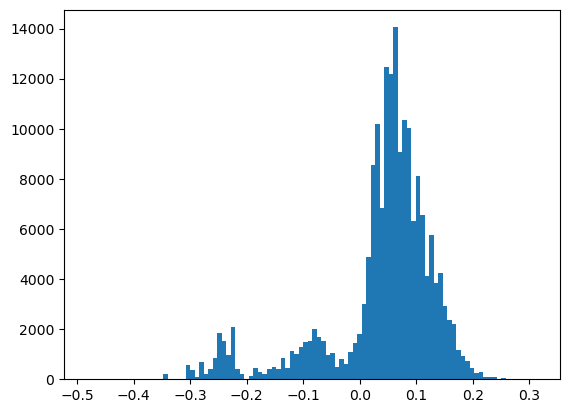

In [11]:
# Pre processing std+normalization 
numVars = data_train.shape[1]
binaryCols = [0,1,2,3] #gl.binaryCols #[0,1,2,3,4]
continiousCols = [4,5] #gl.continiousCols #[5,6]

incomeConsumptionCols = [i for i in np.arange(data_train.shape[1]) if i not in continiousCols + binaryCols]
# trainParameters = preprocessData(data_train,logs=True,std=True,Normalize=True,bandwidth=1.2,typed="Gaussian")
incomColsTrain,continColsTrain,indicatorsDictTrain= preprocessData_colTypes(data_train,
                            incomeConsumptionCOls=incomeConsumptionCols,indicatorCols= binaryCols,continiousCols= continiousCols,
                            logs=True,std=True,Normalize=True,bandwidth=1.2,typed="Gaussian",
                            logsCont=False)

data_train_norm = np.concatenate((indicatorsDictTrain['data'],continColsTrain['data'],incomColsTrain['data']),axis=1)

incomColsTest,continColsTest,indicatorsDictTest= preprocessData_colTypes(data_test,
                            incomeConsumptionCols,indicatorCols= binaryCols,continiousCols= continiousCols,
                            logs=True,std=True,Normalize=True,bandwidth=1.2,typed="Gaussian",
                            logsCont=False)
data_test_norm = np.concatenate((indicatorsDictTest['data'],continColsTest['data'],incomColsTest['data']),axis=1)

loader_args = dict(batch_size=2000, shuffle=True)
train_loader = data.DataLoader(data_train_norm, **loader_args)
test_loader = data.DataLoader(data_test_norm, **loader_args)

plt.hist(data_train_norm[:,-2],bins=100);


# Estimating the Model
Income+Consumption next period Conditional Density estimation

True


Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

0.0001
-2.2959582805633545


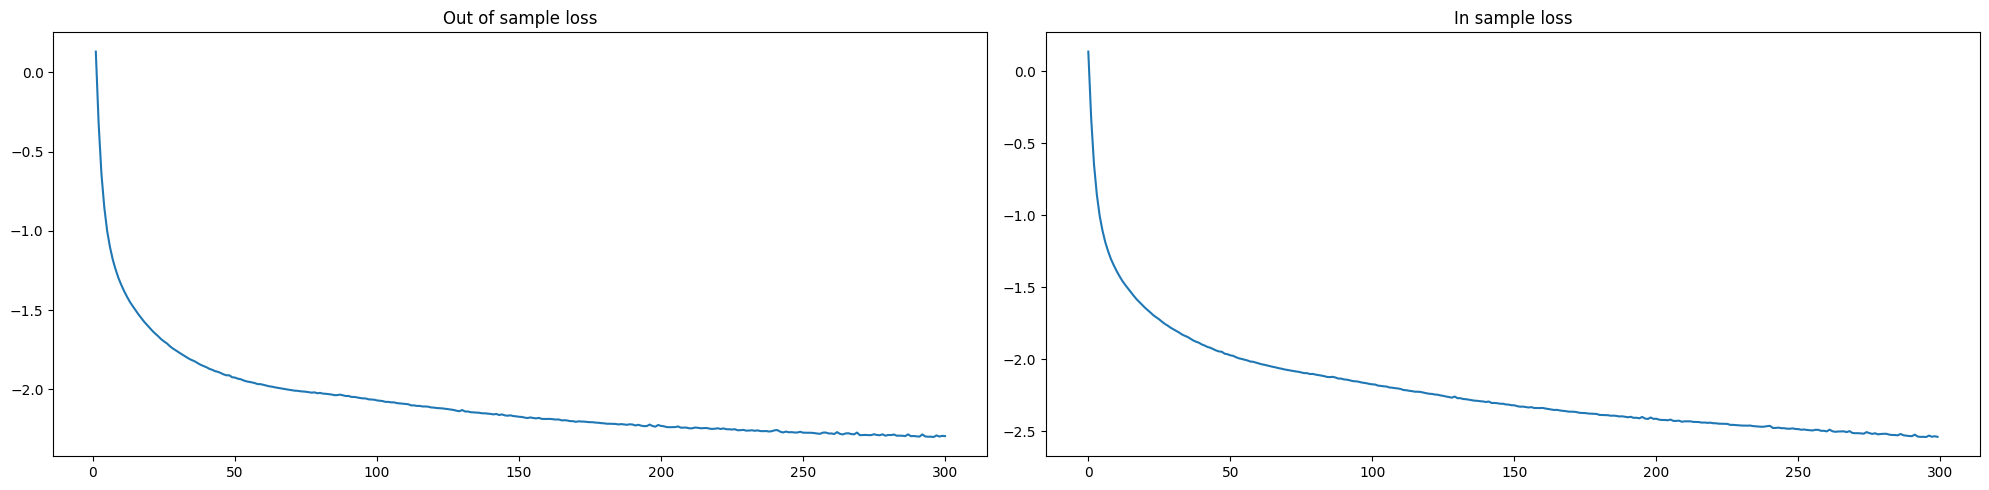

In [22]:

train_args = {
    'epochs': 300,
    'lr' : 1e-4,
    'schedular' : True 
}
#add scheduler 
predictedVars = [-1,-2]
conditionVars = numVars -len(predictedVars)
# gaussian
model =  resBlockAutoRegressiveDynamicFLOW_normalDraws(n_components=8,condVecSize=conditionVars,
                                                        n_blocks=7,base = "gaussian", mixture_dist='gaussian',
                                                        lastColumnToPredict=predictedVars).cuda()
# What seems to be the best now - 7 components in the CDF and 4 Resnet block = stop after 300
# n_block = 5 , n_components=6
print(next(model.parameters()).is_cuda )
losses = train_epochsDynamic(model, train_loader, test_loader, train_args,checkPointSave=[10,20,50,100,150,200,250,300])
print(losses[1][-1])

fig, axs = plt.subplots(1,2,figsize=(20,5))
axs[0].plot(losses[1])
axs[0].set_title('Out of sample loss')
axs[1].plot(losses[2])
axs[1].set_title('In sample loss')
fig.tight_layout()
# plt.savefig('plots/losses_11152022.pdf')  
plt.show()


# Saving the model and model parameters and data

In [ ]:
#Save the model 
torch.save(model, 'proc_data/models/pytorchModel.pt')

#Save Data 
with open('proc_data/temps/data_train.pkl','wb') as f:
    pickle.dump(data_train, f)

with open('proc_data/temps/data_test.pkl','wb') as f:
    pickle.dump(data_test, f)

#Save normalization parameters 
normalizers = {'incomeConsNormalizer':incomColsTrain,
                'continiousNormalizer': continColsTrain,
                'indicNormalizer':indicatorsDictTrain
                }

with open('proc_data/temps/normalizers.pkl','wb') as f:
    pickle.dump(normalizers, f)

parameters = {'binaryCols':binaryCols,
            'continiousCols':continiousCols,
            'maxValue_Income':maxValue_Income,
            'maxValue_Consumption':maxValue_Consumption,
            'minValue_Income':minValue_Income,
            'minValue_Consumtpion':minValue_Consumtpion,
            'beta': beta,
            'R': R
            }

with open('proc_data/temps/parameters.pkl','wb') as f:
    pickle.dump(parameters, f)



# eyeballing model performances

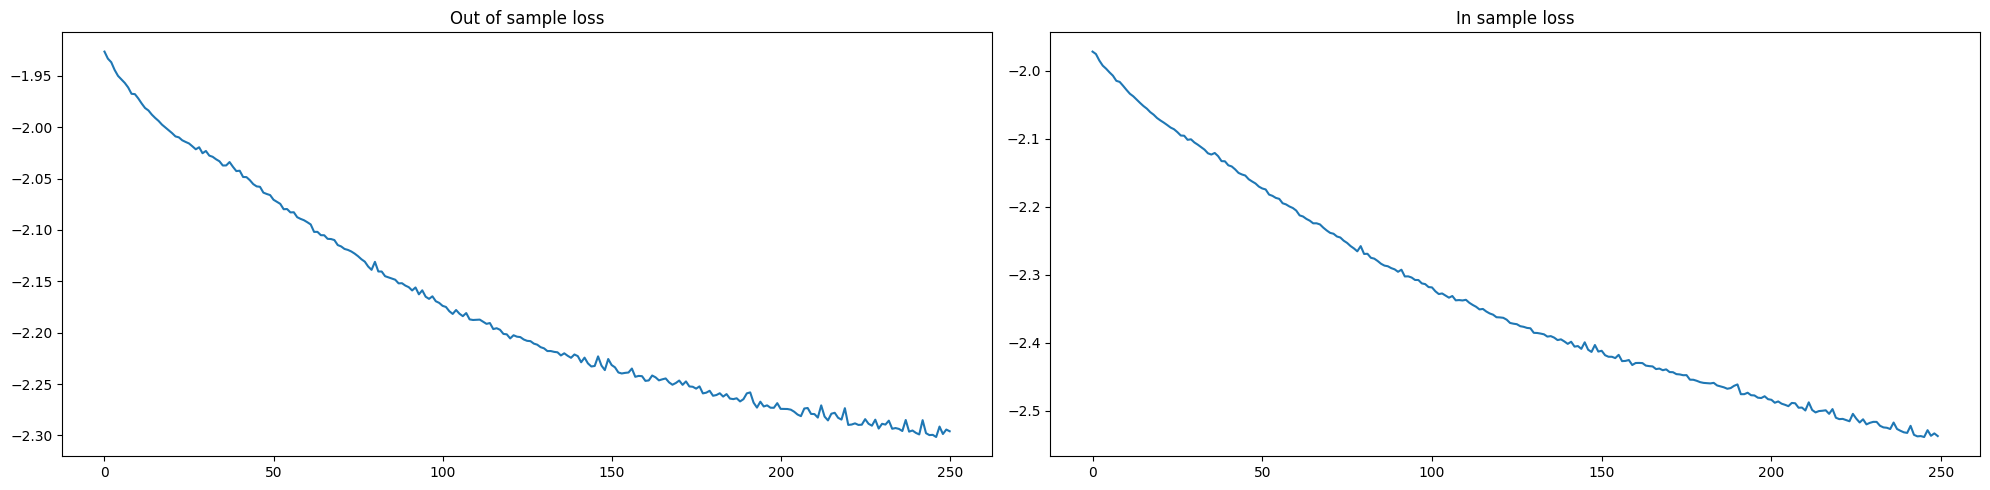

In [24]:
fig, axs = plt.subplots(1,2,figsize=(20,5))
axs[0].plot(losses[1][50:])
axs[0].set_title('Out of sample loss')
axs[1].plot(losses[2][50:])
axs[1].set_title('In sample loss')
fig.tight_layout()
# plt.savefig('plots/losses_11152022.pdf')  
plt.show()


## Comparing the Model samples to Realized Samples

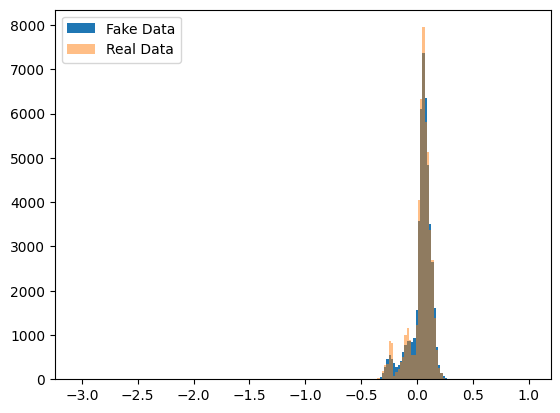

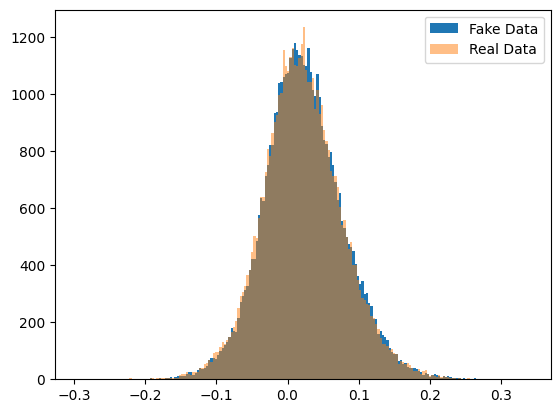

In [26]:
plotHistDemonstration(lastCol=-2,realData = data_test, model=model,contiCols=continiousCols,
                        indCols=binaryCols,incom_dic=incomColsTrain,contin_dic=continColsTrain,
                        binNum=200,truncated=19,save=False,saveName="IncomeHist"
                        )
                        


plotHistDemonstration(lastCol=-1,realData = data_test, model=model,contiCols=continiousCols,
                        indCols=binaryCols,incom_dic=incomColsTrain,contin_dic=continColsTrain,
                        binNum=200,truncated=19,save=False,saveName="consumptionHist"
                        )
                        
#truncated - removes samples that did not converge
                        


## Comparing Moments

Comparing R^2 and Coefficients

Iteration:   0%|          | 0/100 [00:00<?, ?it/s]

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.661
Model:                            OLS   Adj. R-squared:                  0.661
Method:                 Least Squares   F-statistic:                     901.1
Date:                Thu, 05 Jan 2023   Prob (F-statistic):               0.00
Time:                        15:18:42   Log-Likelihood:                 68442.
No. Observations:               47147   AIC:                        -1.367e+05
Df Residuals:                   47044   BIC:                        -1.358e+05
Df Model:                         102                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0198      0.002     13.214      0.0

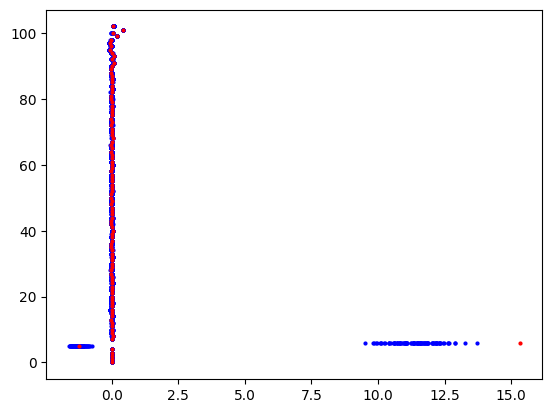

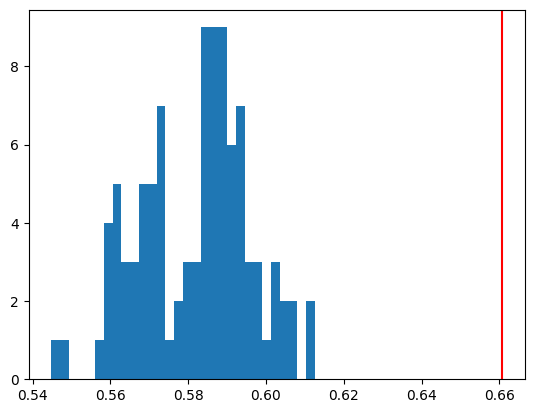

Iteration:   0%|          | 0/100 [00:00<?, ?it/s]

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.752
Model:                            OLS   Adj. R-squared:                  0.751
Method:                 Least Squares   F-statistic:                     1383.
Date:                Thu, 05 Jan 2023   Prob (F-statistic):               0.00
Time:                        15:21:04   Log-Likelihood:             1.0141e+05
No. Observations:               47147   AIC:                        -2.026e+05
Df Residuals:                   47043   BIC:                        -2.017e+05
Df Model:                         103                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0011      0.001      1.428      0.1

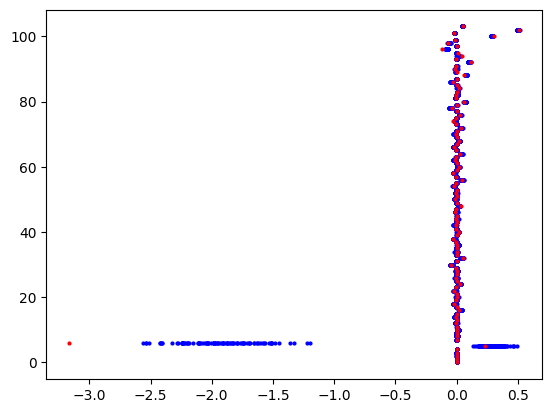

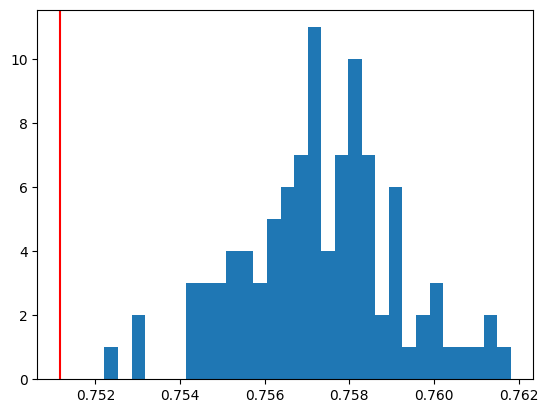

In [27]:
monteCarloForR2andBeta(lastCol=-2,realData = data_test, model=model,contiCols=continiousCols,
                        indCols=binaryCols,incom_dic=incomColsTrain,contin_dic=continColsTrain,
                        iterations=100,verbose=True)


monteCarloForR2andBeta(lastCol=-1,realData = data_test, model=model,contiCols=continiousCols,
                        indCols=binaryCols,incom_dic=incomColsTrain,contin_dic=continColsTrain,
                        iterations=100,verbose=True)


## Plotting Densities

plotting the estimated density for random dudes

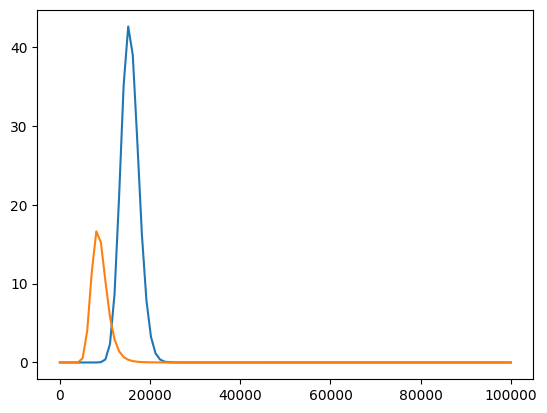

starting Joint


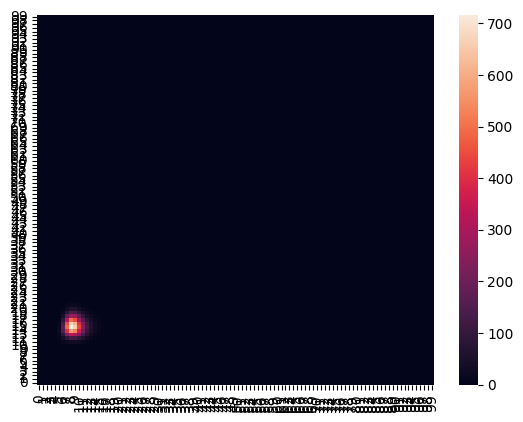

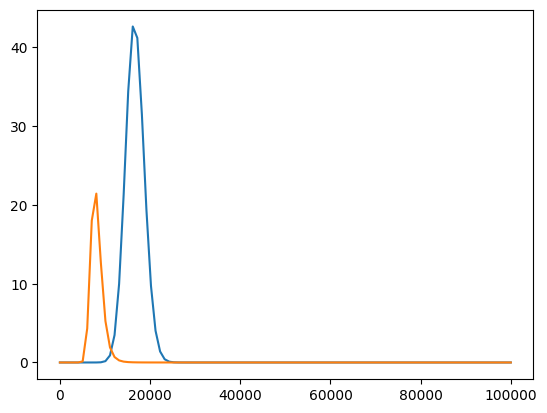

starting Joint


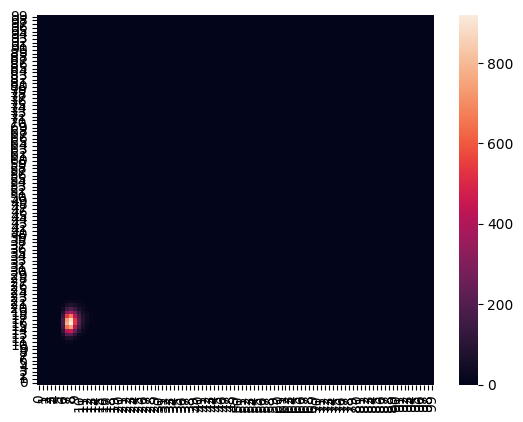

In [28]:
plotDensity(data_test[20,:],model,contiCols=continiousCols,
                        indCols=binaryCols,incom_dic=incomColsTrain,contin_dic=continColsTrain)
plotDensity(data_test[225,:],model,contiCols=continiousCols,
                        indCols=binaryCols,incom_dic=incomColsTrain,contin_dic=continColsTrain)


## Generating Panel Data to eyeball

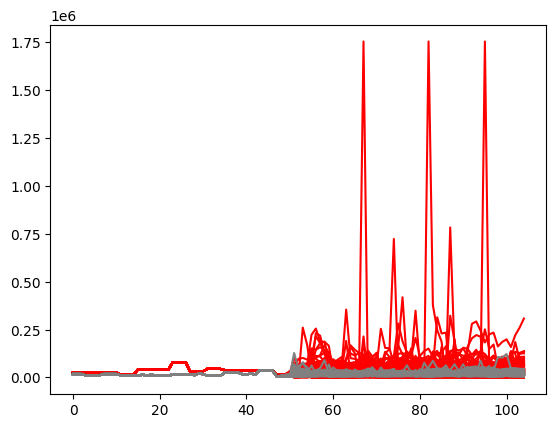

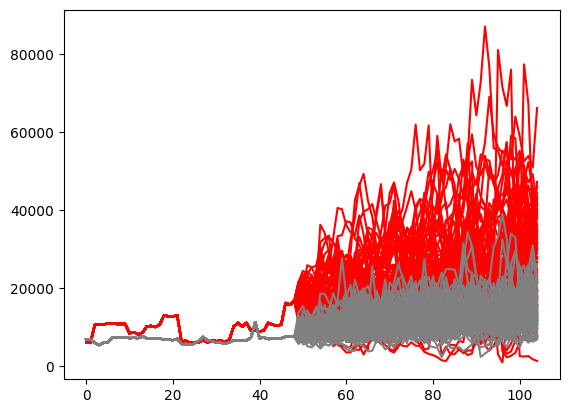

In [32]:
aGuy = np.tile(data_test[20,:],(100,1))
sample, OG_ageCapital,_ = genPanelData(aGuy,model,contiCols=continiousCols,indCols=binaryCols,
                        incom_dic=incomColsTrain,contin_dic=continColsTrain,
                        R=(1+0.0051585),colList=[-2,-1],T = 60)
sampleINV = invData(sample,contiCols=continiousCols,indCols=binaryCols,
                incom_dic=incomColsTrain,contin_dic=continColsTrain,
                    incomeUB=maxValue_Income,consumptionUB=maxValue_Consumption,
                    incomeLB=minValue_Income,consumptionLB=minValue_Consumtpion)

nonIncConCols = len(binaryCols)+len(continiousCols)
numCols = sampleINV[:,nonIncConCols:].shape[1]
plt.plot(sampleINV[:,np.arange(nonIncConCols,numCols,2)].T,color='red');
plt.plot(sampleINV[:,np.arange(nonIncConCols+1,numCols,2)].T,color='grey');
# plt.savefig('presentation_outputs/figures_slides_11062022/guy1.pdf')  
plt.show()


aGuy = np.tile(data_test[225,:],(100,1))
sample, OG_ageCapital,_ = genPanelData(aGuy,model,contiCols=continiousCols,
                        indCols=binaryCols,incom_dic=incomColsTrain,contin_dic=continColsTrain,
                        R=(1+0.0051585),colList=[-2,-1],T = 60)
sampleINV = invData(sample,contiCols=continiousCols,indCols=binaryCols,
                incom_dic=incomColsTrain,contin_dic=continColsTrain,
                    incomeUB=maxValue_Income,consumptionUB=maxValue_Consumption,
                    incomeLB=minValue_Income,consumptionLB=minValue_Consumtpion)

nonIncConCols = len(binaryCols)+len(continiousCols)
numCols = sampleINV[:,nonIncConCols:].shape[1]
plt.plot(sampleINV[:,np.arange(nonIncConCols,numCols,2)].T,color='red');
plt.plot(sampleINV[:,np.arange(nonIncConCols+1,numCols,2)].T,color='grey');
# plt.savefig('presentation_outputs/figures_slides_11062022/guy1.pdf')  
plt.show()



## eyeballing effect of changes in group membership, wealth

In [ ]:
def analyze_caste_variables_impact(val, data_test, model, contiCols, binaryCols, incom_dic, contin_dic):
    """
    Analyzes the impact of activating each of the first four binary variables in a data point.
    It zeroes out these variables and then sets each one to 1 individually to see its specific effect.
    After each modification, it prints the modified part of the data point and plots the density
    to assess the change's impact on the model's output.
    """
    # Activate the first binary variable and plot the density
    changeGroup = data_test[val, :].copy()
    changeGroup[0:4] = 0
    changeGroup[0] = 1
    print(changeGroup[:4])
    plotDensity(changeGroup, model, contiCols=contiCols, indCols=binaryCols, incom_dic=incom_dic, contin_dic=contin_dic, joint=False)

    # Repeat for the second binary variable
    changeGroup1 = data_test[val, :].copy()
    changeGroup1[0:4] = 0
    changeGroup1[1] = 1
    print(changeGroup1[:4])
    plotDensity(changeGroup1, model, contiCols=contiCols, indCols=binaryCols, incom_dic=incom_dic, contin_dic=contin_dic, joint=False)

    # Repeat for the third binary variable
    changeGroup2 = data_test[val, :].copy()
    changeGroup2[0:4] = 0
    changeGroup2[2] = 1
    print(changeGroup2[:4])
    plotDensity(changeGroup2, model, contiCols=contiCols, indCols=binaryCols, incom_dic=incom_dic, contin_dic=contin_dic, joint=False)

    # Repeat for the fourth binary variable
    changeGroup3 = data_test[val, :].copy()
    changeGroup3[0:4] = 0
    changeGroup3[3] = 1
    print(changeGroup3[:4])
    plotDensity(changeGroup3, model, contiCols=contiCols, indCols=binaryCols, incom_dic=incom_dic, contin_dic=contin_dic, joint=False)


# Function to analyze the impact of varying a continuous variable at index 4
def analyze_wealth_variable_impact_index4(val, data_test, model, contiCols, binaryCols, incom_dic, contin_dic):
    """
    Modifies the wealth at index 4 to different values (400, 600, 800, 700)
    and analyzes its impact on the model's output. After each modification, it prints the first five elements
    (to include the modified one) and plots the density for visual analysis of the impact.
    """
    # Modify the continuous variable to 400 and plot the density
    changeGroup = data_test[val, :].copy()
    changeGroup[4] = 400
    print(changeGroup[:5])
    plotDensity(changeGroup, model, contiCols=contiCols, indCols=binaryCols, incom_dic=incom_dic, contin_dic=contin_dic, joint=False)

    # Repeat with the variable set to 600
    changeGroup1 = data_test[val, :].copy()
    changeGroup1[4] = 600
    print(changeGroup1[:5])
    plotDensity(changeGroup1, model, contiCols=contiCols, indCols=binaryCols, incom_dic=incom_dic, contin_dic=contin_dic, joint=False)

    # Repeat with the variable set to 800
    changeGroup2 = data_test[val, :].copy()
    changeGroup2[4] = 800
    print(changeGroup2[:5])
    plotDensity(changeGroup2, model, contiCols=contiCols, indCols=binaryCols, incom_dic=incom_dic, contin_dic=contin_dic, joint=False)

    # Repeat with the variable set to 700
    changeGroup3 = data_test[val, :].copy()
    changeGroup3[4] = 700
    print(changeGroup3[:5])
    plotDensity(changeGroup3, model, contiCols=contiCols, indCols=binaryCols, incom_dic=incom_dic, contin_dic=contin_dic, joint=False)




In [ ]:
analyze_caste_variables_impact(600, data_test, model, contiCols=continiousCols, binaryCols=binaryCols, incom_dic=incomColsTrain, contin_dic=continColsTrain)
analyze_wealth_variable_impact_index4(1567, data_test, model, contiCols=continiousCols, binaryCols=binaryCols, incom_dic=incomColsTrain, contin_dic=continColsTrain)
